# Compute metrics on data using stratification 

In [3]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os

In [2]:
temperature_data = pd.read_csv('simulation_results/clean_data/all_temperatures.csv')

(array([  2.,   1.,   1.,   0.,   1.,   1.,   2.,   1.,   0.,   2.,   0.,
          0.,   1.,   1.,   1.,   4.,   3.,   2.,   7.,   3.,   3.,   1.,
          2.,   5.,   1.,   9.,   3.,   1.,   3.,   4.,   3.,   3.,   1.,
          4.,   4.,   5.,   4.,  10.,  11.,   4.,   8.,   8.,   8.,  19.,
          4.,   2.,  13.,  18.,   8.,  17.,  39.,  18.,  19.,  28.,  23.,
         21.,  52.,  24.,  32.,  24.,  33.,  32.,  63.,  41.,  44.,  37.,
         38.,  54.,  92.,  33.,  50.,  52.,  52.,  54.,  58., 131.,  64.,
         70.,  48.,  64.,  48., 131.,  50.,  59.,  33.,  49.,  42., 117.,
         55.,  64.,  48.,  56.,  72., 116.,  54.,  52.,  46.,  52.,  47.,
         42.,  95.,  43.,  36.,  45.,  31.,  56.,  61.,  23.,  24.,  28.,
         25.,  35.,  55.,  31.,  22.,  25.,  22.,  15.,  29.,  17.,  18.,
         32.,  14.,  19.,  26.,  37.,  12.,  12.,  14.,   9.,  14.,  32.,
         14.,  16.,  26.,  19.,  15.,  25.,  13.,  12.,  13.,   9.,  12.,
         17.,   8.,   5.,   7.,   3., 

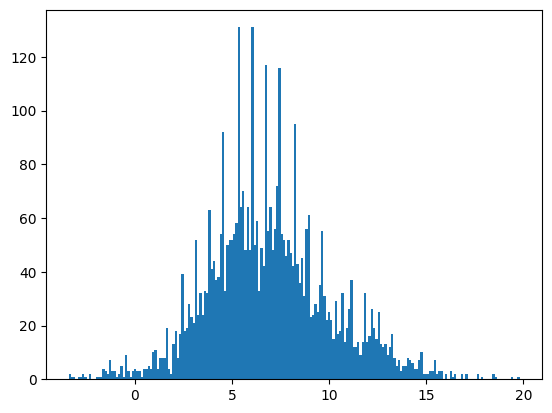

In [3]:
plt.hist(temperature_data['temp'], bins=200)

In [4]:

# divide in quantiles
temperature_data['quantile'] = pd.qcut(temperature_data['temp'], 
                                        q=11)

quantile_bins = temperature_data['quantile'].cat.categories



In [5]:
from src.data_loader import load_data
from src.metrics import *

results_pid_nominal = load_data('pid', 'nominal')
results_pid_with_noise = load_data('pid', 'noise')
results_pid_with_disturbances = load_data('pid', 'disturbances')

results_onoff_nominal = load_data('onoff', 'nominal')
results_onoff_with_noise = load_data('onoff', 'noise')
results_onoff_with_disturbances = load_data('onoff', 'disturbances')

results_fuzzy_nominal = load_data('fuzzy', 'nominal')
results_fuzzy_with_noise = load_data('fuzzy', 'noise')
results_fuzzy_with_disturbances = load_data('fuzzy', 'disturbances')

metrics = [steady_state_error, mean_square_error, overshoot, comfort_time, 
            energy_consumed, settling_time, rise_time, number_of_oscillations, recovery_time]

results = {
    "results_pid_nominal": results_pid_nominal,
    "results_pid_with_noise": results_pid_with_noise,
    "results_pid_with_disturbances": results_pid_with_disturbances,
     "results_onoff_nominal": results_onoff_nominal,
     "results_onoff_with_noise": results_onoff_with_noise,
     "results_onoff_with_disturbances": results_onoff_with_disturbances,
     "results_fuzzy_nominal": results_fuzzy_nominal,
     "results_fuzzy_with_noise": results_fuzzy_with_noise,
     "results_fuzzy_with_disturbances": results_fuzzy_with_disturbances,
}

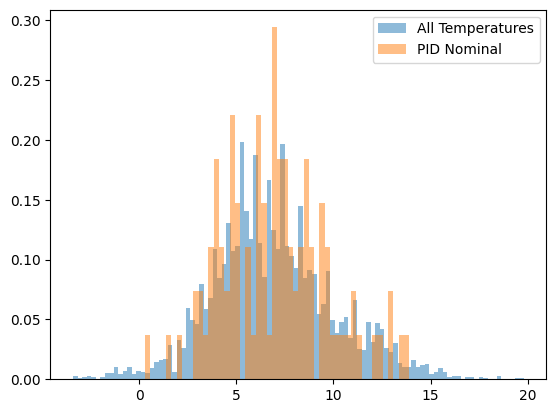

In [ ]:
plt.hist(temperature_data['temp'], bins=100, alpha=0.5, label='All Temperatures', density=True)
outsideTemp =  [df['outsideTemp'].iloc[0] for df in results_pid_nominal]
plt.hist(outsideTemp, bins=50, alpha=0.5, label='PID Nominal', density=True)

outsideTemp = pd.DataFrame(outsideTemp, columns=['outsideTemp'])
outsideTemp.to_csv('simulation_results/clean_data/outside_temp_pid_nominal.csv')
plt.legend()

In [15]:


def precompute_metric_values(scenario_results, metric_fn):
    """Precompute the metric value for each simulation, skipping NaN results."""
    results = []
    for df in scenario_results:
        value = metric_fn(df, 'temperatureSensor_T', 20.0, 'windowState')
        if pd.isna(value):
            continue  # skip simulations with NaN metric
        results.append({
            'df': df,
            'initial_temp': df['outsideTemp'].iloc[0],
            'value': value
        })
    return results


def stratify(precomputed, quantile_bins):
    """Stratify precomputed results by initial temperature"""
    temps = [entry['initial_temp'] for entry in precomputed]
    labels = pd.cut(temps, bins=quantile_bins)
    strata = {}

    for entry, label in zip(precomputed, labels):
        strata.setdefault(label, []).append(entry['value'])

    return strata


def stratified_bootstrap_ci(precomputed, quantile_bins, num_samples=1000, confidence=0.95):
    strata = stratify(precomputed, quantile_bins)
    combined_means = []

    for _ in range(num_samples):
        print(f"Bootstrap iteration {_ + 1}/{num_samples}")
        stratum_means = []
        for values in strata.values():
            if not values:
                continue
            resampled = random.choices(values, k=len(values))
            stratum_means.append(np.mean(resampled))
        combined_means.append(np.mean(stratum_means))

    lower = np.percentile(combined_means, (1 - confidence) / 2 * 100)
    upper = np.percentile(combined_means, (1 + confidence) / 2 * 100)
    mean = np.mean(combined_means)
    return mean, lower, upper


#def stratified_bootstrap_variance_ci(precomputed, quantile_bins, num_samples=1000, confidence=0.95):
#    strata = stratify(precomputed, quantile_bins)
#    combined_variances = []
#
#    for _ in range(num_samples):
#        stratum_means = []
#        for values in strata.values():
#            if not values:
#                continue
#            resampled = random.choices(values, k=len(values))
#            stratum_means.append(np.mean(resampled))
#        combined_variances.append(np.var(stratum_means, ddof=1))
#
#    lower = np.percentile(combined_variances, (1 - confidence) / 2 * 100)
#    upper = np.percentile(combined_variances, (1 + confidence) / 2 * 100)
#    var = np.mean(combined_variances)
#    return var, lower, upper

def stratified_estimator_variance(precomputed, quantile_bins):
    
    strata = stratify(precomputed, quantile_bins)
    total_n = sum(len(values) for values in strata.values())
    variance = 0.0

    for values in strata.values():
        n_k = len(values)
        if n_k < 2:
            continue  # skip or assume zero variance if not enough data
        w_k = n_k / total_n
        s_k2 = np.var(values, ddof=1)  # unbiased sample variance
        variance += (w_k ** 2) * (s_k2 / n_k)

    return variance


def calculate_and_export_stats(scenario_results, metrics, scenario_name):
    aggregated_stats = []
    long_format_records = []

    for metric in metrics:
        # 1. Precompute values only once
        precomputed = precompute_metric_values(scenario_results, metric)

        # 2. Confidence intervals using precomputed values
        mean, mean_ci_lower, mean_ci_upper = stratified_bootstrap_ci(precomputed, quantile_bins)
        var = stratified_estimator_variance(precomputed, quantile_bins)

        # 3. Store overall results
        aggregated_stats.append({
            'metric': metric.__name__,
            'mean': mean,
            'mean_ci_lower': mean_ci_lower,
            'mean_ci_upper': mean_ci_upper,
            'var': var,
            'var_ci_lower': 0.0,  # Placeholder for variance CI, not computed here
            'var_ci_upper': 0.0  # Placeholder for variance CI, not computed here
        })

        # 4. Export per-simulation values
        for i, entry in enumerate(precomputed):
            long_format_records.append({
                'controller': scenario_name,
                'run': i,
                'metric': metric.__name__,
                'value': entry['value']
            })

    # Export results
    pd.DataFrame(aggregated_stats).to_csv(f"simulation_results/statistics/{scenario_name}_aggregated_low_var.csv", index=False)
    pd.DataFrame(long_format_records).to_csv(f"simulation_results/statistics/{scenario_name}_all_low_var.csv", index=False)


In [16]:
for name, scenario in results.items():
    calculate_and_export_stats(scenario, metrics, scenario_name=name)
    print(f"Stats for {name} calculated and exported.")


Bootstrap iteration 1/1000
Bootstrap iteration 2/1000
Bootstrap iteration 3/1000
Bootstrap iteration 4/1000
Bootstrap iteration 5/1000
Bootstrap iteration 6/1000
Bootstrap iteration 7/1000
Bootstrap iteration 8/1000
Bootstrap iteration 9/1000
Bootstrap iteration 10/1000
Bootstrap iteration 11/1000
Bootstrap iteration 12/1000
Bootstrap iteration 13/1000
Bootstrap iteration 14/1000
Bootstrap iteration 15/1000
Bootstrap iteration 16/1000
Bootstrap iteration 17/1000
Bootstrap iteration 18/1000
Bootstrap iteration 19/1000
Bootstrap iteration 20/1000
Bootstrap iteration 21/1000
Bootstrap iteration 22/1000
Bootstrap iteration 23/1000
Bootstrap iteration 24/1000
Bootstrap iteration 25/1000
Bootstrap iteration 26/1000
Bootstrap iteration 27/1000
Bootstrap iteration 28/1000
Bootstrap iteration 29/1000
Bootstrap iteration 30/1000
Bootstrap iteration 31/1000
Bootstrap iteration 32/1000
Bootstrap iteration 33/1000
Bootstrap iteration 34/1000
Bootstrap iteration 35/1000
Bootstrap iteration 36/1000
B

/home/chiara/unitn/master/spe/project/venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/chiara/unitn/master/spe/project/venv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Bootstrap iteration 1/1000
Bootstrap iteration 2/1000
Bootstrap iteration 3/1000
Bootstrap iteration 4/1000
Bootstrap iteration 5/1000
Bootstrap iteration 6/1000
Bootstrap iteration 7/1000
Bootstrap iteration 8/1000
Bootstrap iteration 9/1000
Bootstrap iteration 10/1000
Bootstrap iteration 11/1000
Bootstrap iteration 12/1000
Bootstrap iteration 13/1000
Bootstrap iteration 14/1000
Bootstrap iteration 15/1000
Bootstrap iteration 16/1000
Bootstrap iteration 17/1000
Bootstrap iteration 18/1000
Bootstrap iteration 19/1000
Bootstrap iteration 20/1000
Bootstrap iteration 21/1000
Bootstrap iteration 22/1000
Bootstrap iteration 23/1000
Bootstrap iteration 24/1000
Bootstrap iteration 25/1000
Bootstrap iteration 26/1000
Bootstrap iteration 27/1000
Bootstrap iteration 28/1000
Bootstrap iteration 29/1000
Bootstrap iteration 30/1000
Bootstrap iteration 31/1000
Bootstrap iteration 32/1000
Bootstrap iteration 33/1000
Bootstrap iteration 34/1000
Bootstrap iteration 35/1000
Bootstrap iteration 36/1000
B

In [1]:


def compare_and_plot(original_file, stratified_file, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    # === LOAD AND CLEAN DATA ===
    orig = pd.read_csv(original_file).set_index("metric").dropna()
    strat = pd.read_csv(stratified_file).set_index("metric").dropna()

    common_metrics = orig.index.intersection(strat.index)
    if common_metrics.empty:
        print(f"No common metrics in: {original_file}")
        return

    # === CALCULATE VARIANCE REDUCTION ===
    comparison_df = pd.DataFrame(index=common_metrics)
    comparison_df["original_var"] = orig.loc[common_metrics, "var"]
    comparison_df["stratified_var"] = strat.loc[common_metrics, "var"]
    comparison_df["reduction_%"] = 100 * (
        comparison_df["original_var"] - comparison_df["stratified_var"]
    ) / comparison_df["original_var"]

    # === ADD MEAN ± CI INFO ===
    for prefix, df in [("original", orig), ("stratified", strat)]:
        comparison_df[f"{prefix}_mean"] = df.loc[common_metrics, "mean"]
        comparison_df[f"{prefix}_ci_low"] = df.loc[common_metrics, "mean_ci_lower"]
        comparison_df[f"{prefix}_ci_up"] = df.loc[common_metrics, "mean_ci_upper"]

    # === PRINT REDUCTION TABLE ===
    print(f"\n📊 Variance reduction for: {os.path.basename(original_file)}")
    print(comparison_df[["original_var", "stratified_var", "reduction_%"]].round(4))

    # === PLOT EACH METRIC ===
    for metric in common_metrics:
        fig, ax = plt.subplots(figsize=(6, 4))
        data = comparison_df.loc[metric]

        # Mean and CI values
        orig_mean = data["original_mean"]
        strat_mean = data["stratified_mean"]
        orig_err = [
            orig_mean - data["original_ci_low"],
            data["original_ci_up"] - orig_mean
        ]
        strat_err = [
            strat_mean - data["stratified_ci_low"],
            data["stratified_ci_up"] - strat_mean
        ]

        # Plotting
        ax.errorbar(0, orig_mean, yerr=[[orig_err[0]], [orig_err[1]]],
                    fmt='o', label="Original", capsize=5)
        ax.errorbar(1, strat_mean, yerr=[[strat_err[0]], [strat_err[1]]],
                    fmt='s', label="Stratified", capsize=5)

        ax.set_xticks([0, 1])
        ax.set_xticklabels(["Original", "Stratified"])
        ax.set_title(f"Mean ± CI: {metric}]")
        ax.set_ylabel("Value")
        ax.legend()
        ax.grid(True)
        output_file = f"{output_dir}/{metric}_comparison_{os.path.basename(original_file)}.png"
        plt.savefig(output_file)
        plt.tight_layout()

       
    

    


📊 Variance reduction for: results_pid_nominal_aggregated.csv
                        original_var  stratified_var  reduction_%
metric                                                           
steady_state_error            0.0000          0.0000      90.2741
mean_square_error             0.0000          0.0000      96.8007
overshoot                     0.0000          0.0000      81.6342
rise_time                   986.3126         40.2663      95.9175
settling_time               271.9866          7.7795      97.1398
comfort_time                269.6295          7.7795      97.1148
energy_consumed               0.0001          0.0000      93.6940
number_of_oscillations        0.0012          0.0003      73.3037

📊 Variance reduction for: results_pid_with_noise_aggregated.csv
                        original_var  stratified_var  reduction_%
metric                                                           
steady_state_error            0.0000          0.0000      90.1377
mean_square_err

/tmp/ipykernel_10587/1025594655.py:33: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(6, 4))



📊 Variance reduction for: results_onoff_nominal_aggregated.csv
                        original_var  stratified_var  reduction_%
metric                                                           
steady_state_error            0.0000          0.0000      96.1043
mean_square_error             0.0000          0.0000      97.7530
overshoot                     0.0000          0.0000      92.1826
rise_time                     3.8533          0.1014      97.3672
settling_time                 2.9121          0.0758      97.3962
comfort_time                  3.2762          0.0758      97.6855
energy_consumed               0.0001          0.0000      93.0969
number_of_oscillations        0.0000          0.0000          NaN

📊 Variance reduction for: results_onoff_with_noise_aggregated.csv
                        original_var  stratified_var  reduction_%
metric                                                           
steady_state_error            0.0000          0.0000      92.5415
mean_square

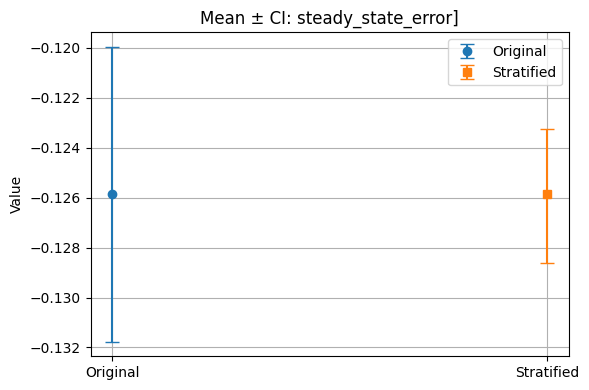

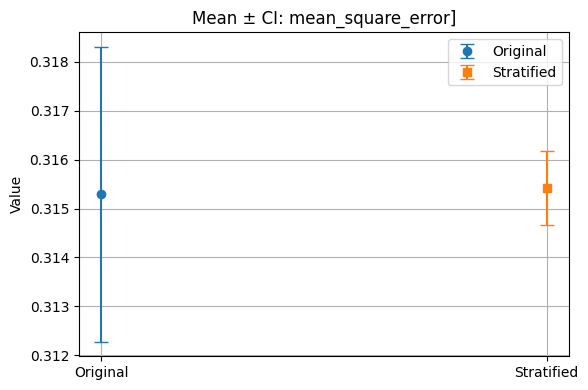

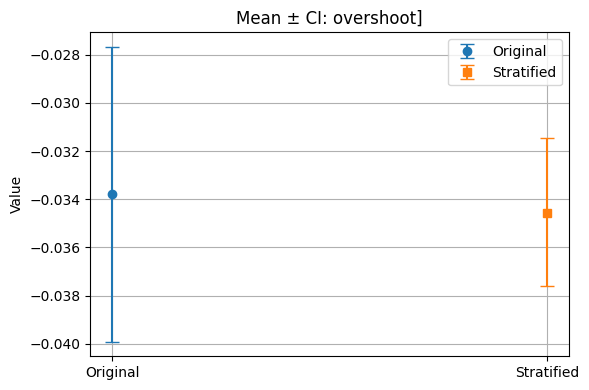

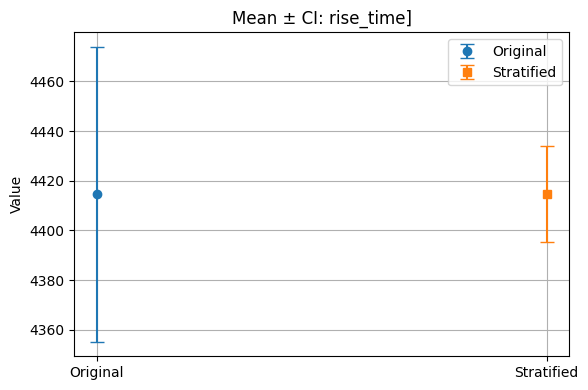

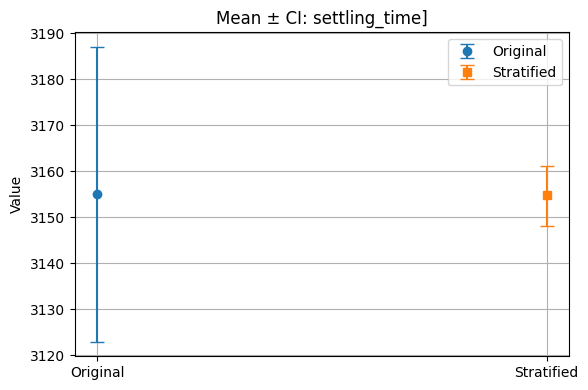

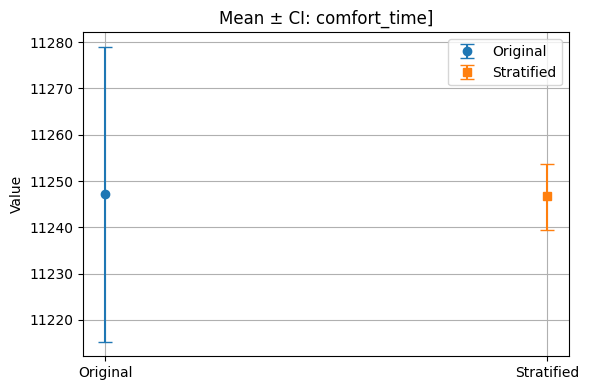

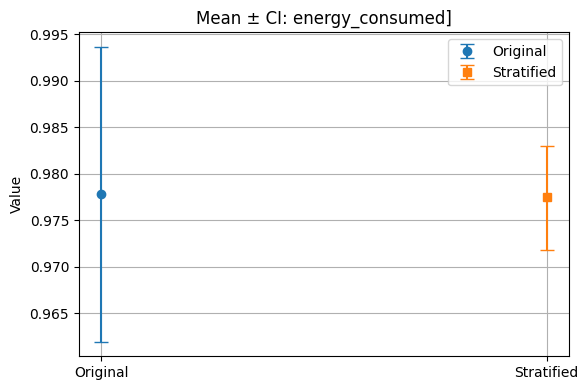

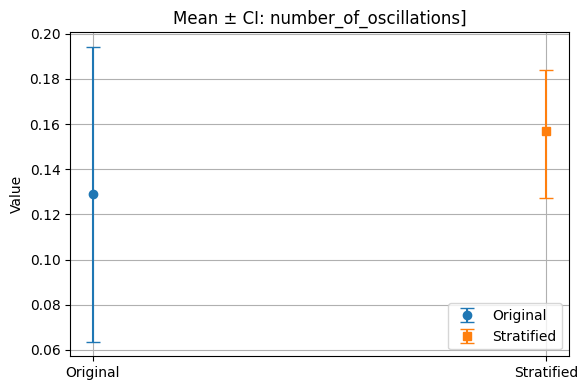

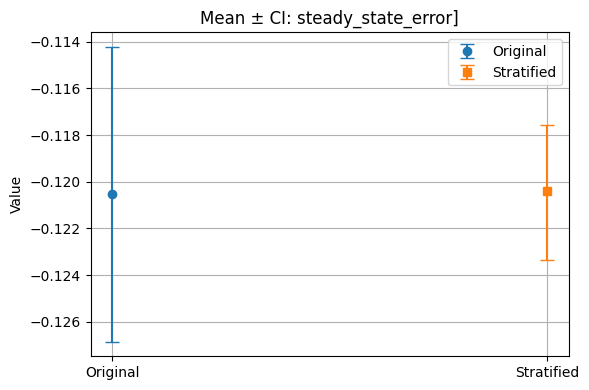

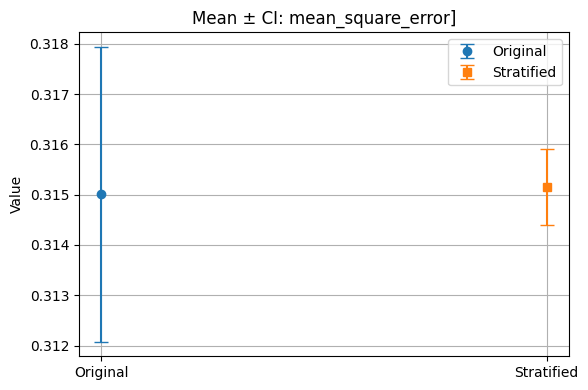

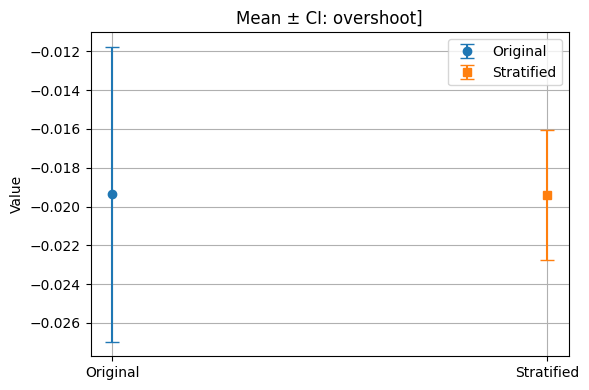

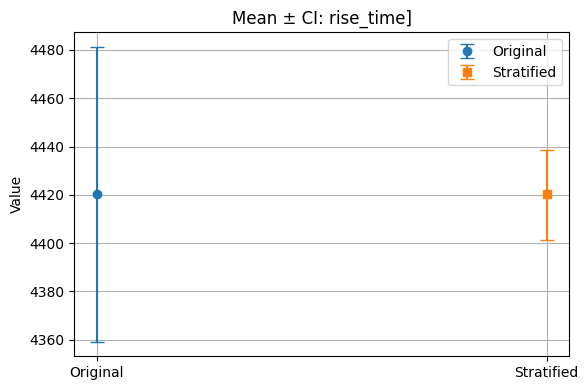

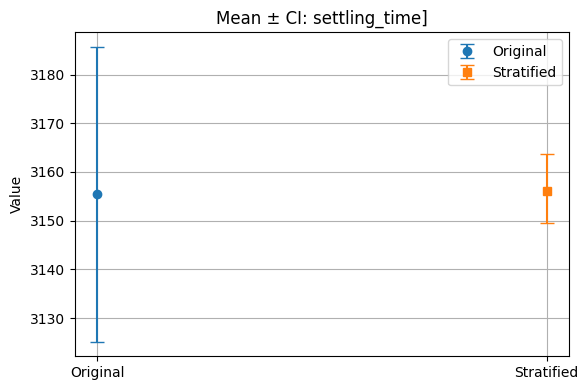

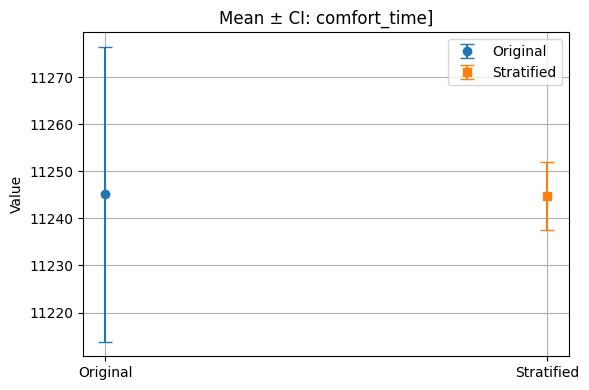

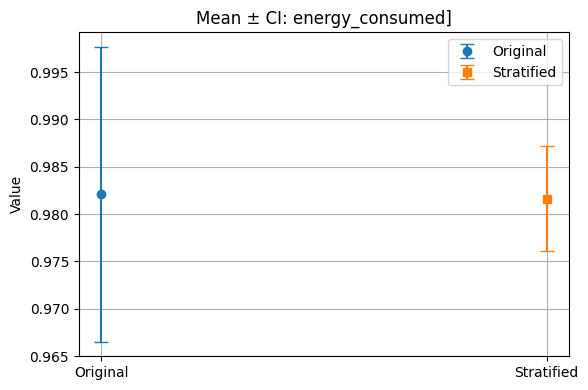

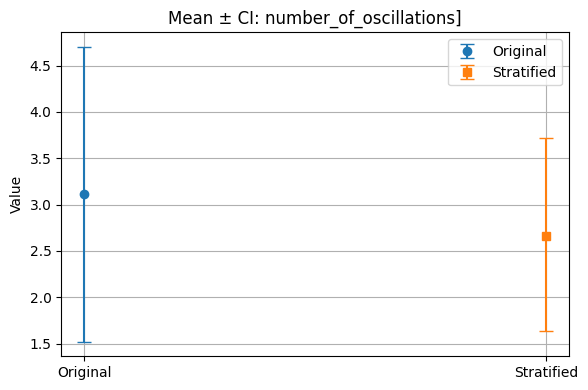

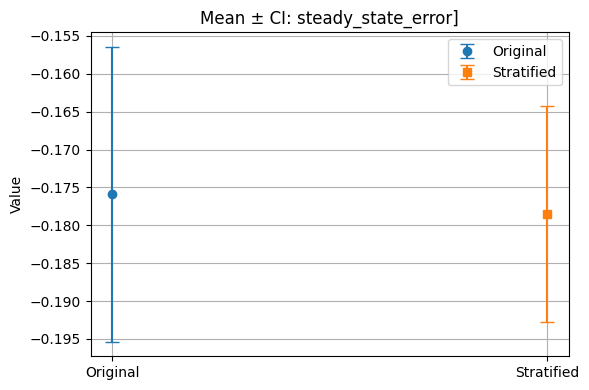

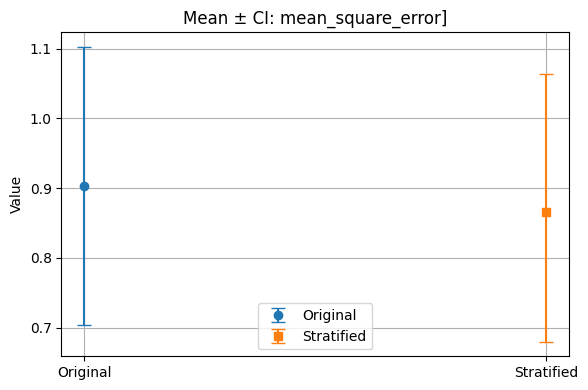

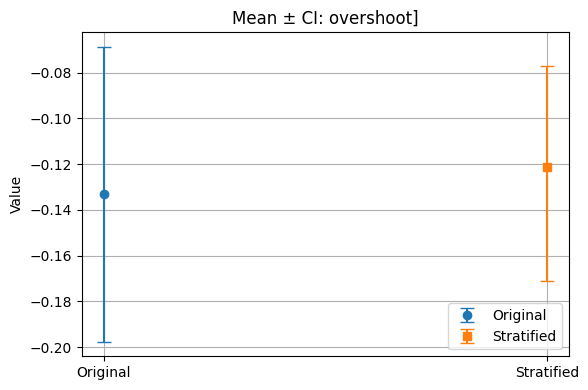

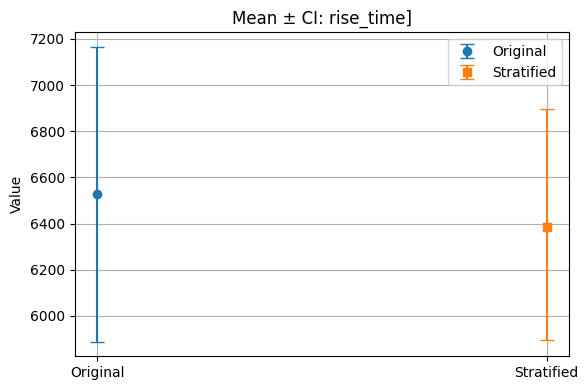

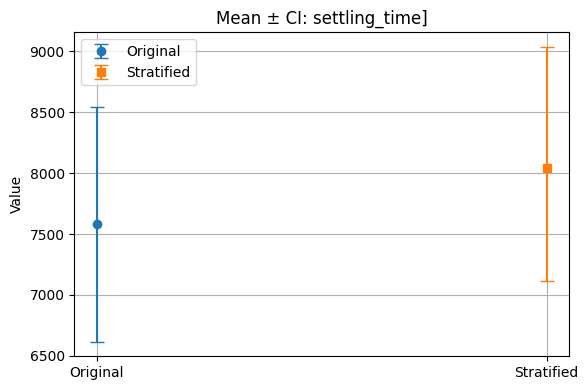

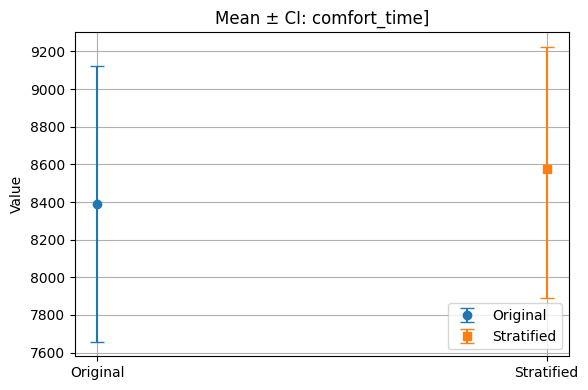

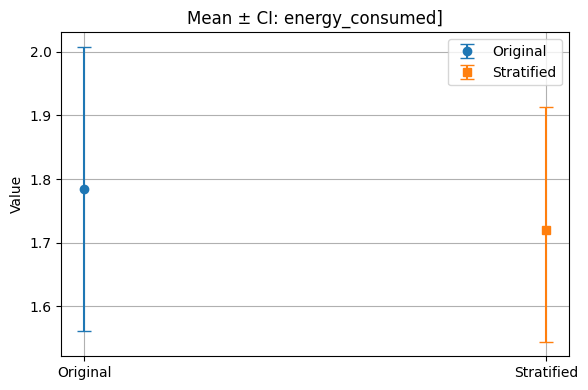

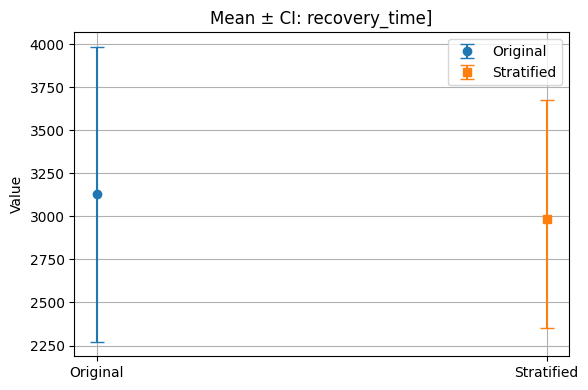

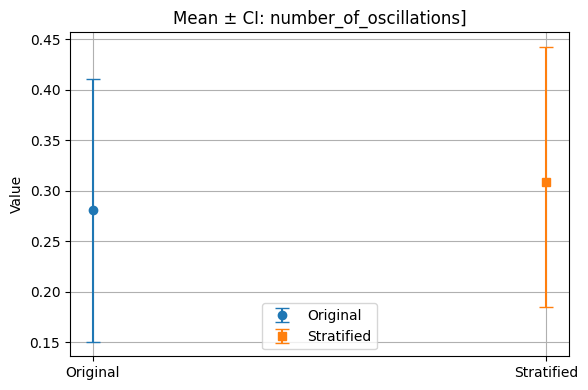

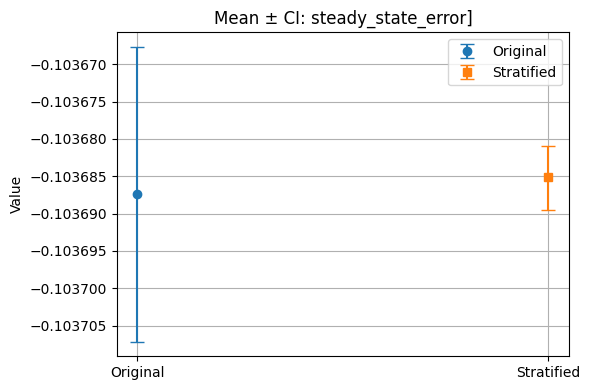

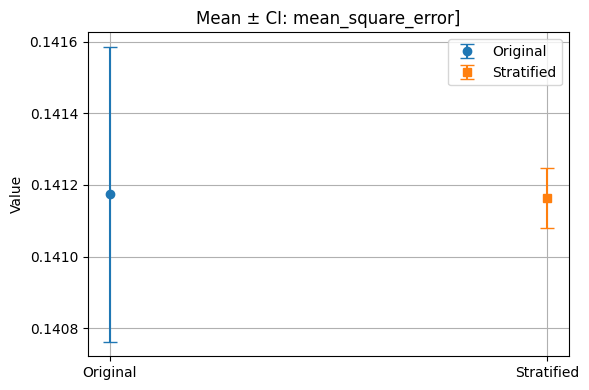

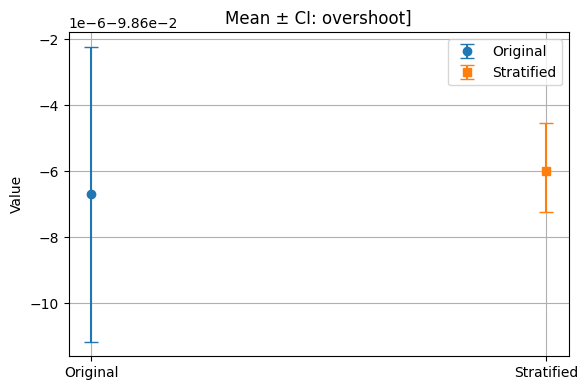

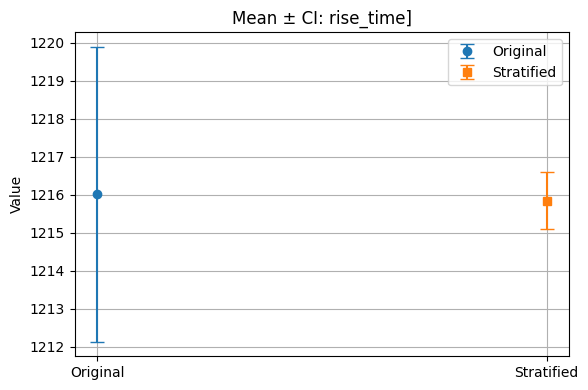

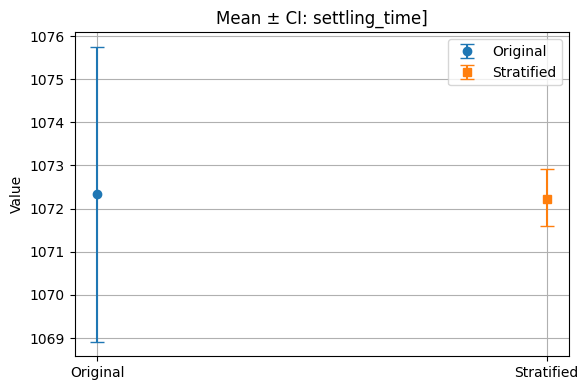

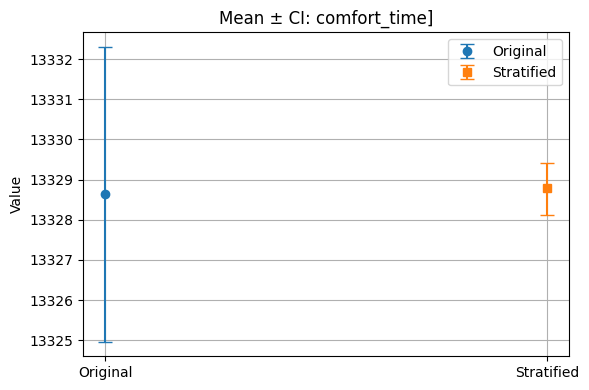

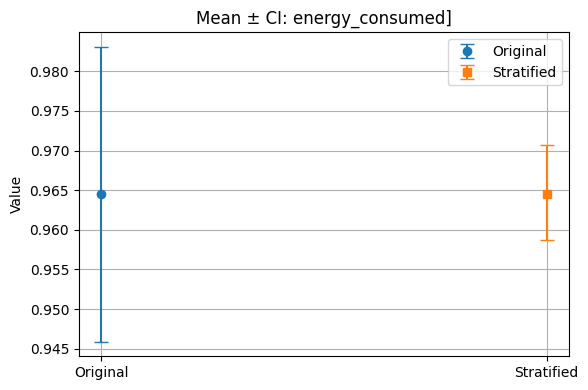

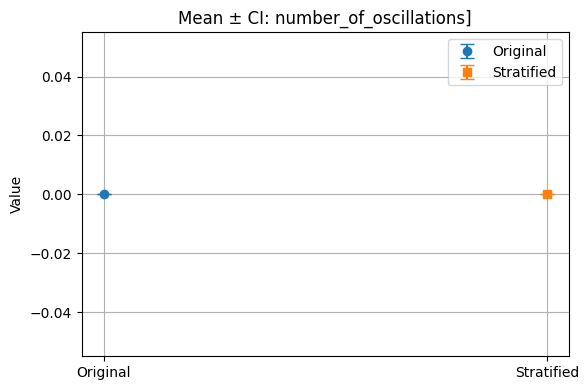

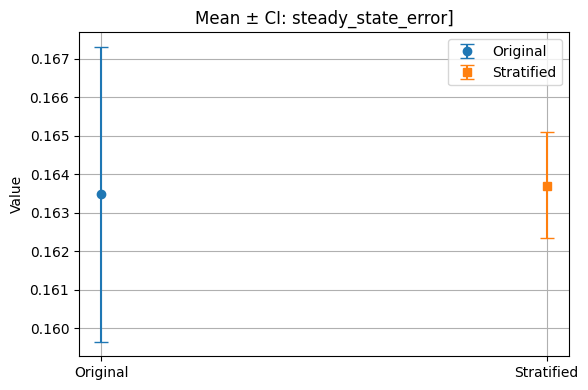

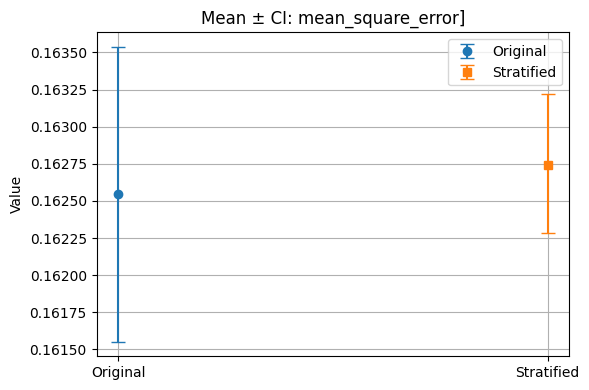

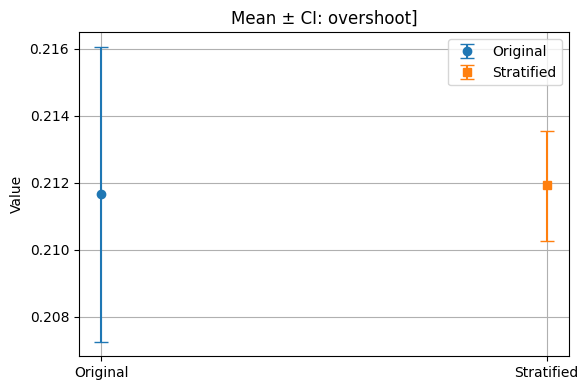

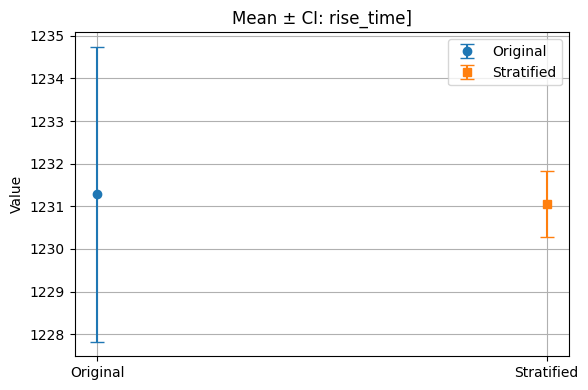

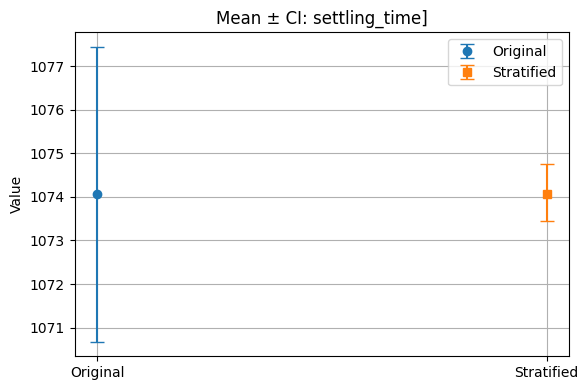

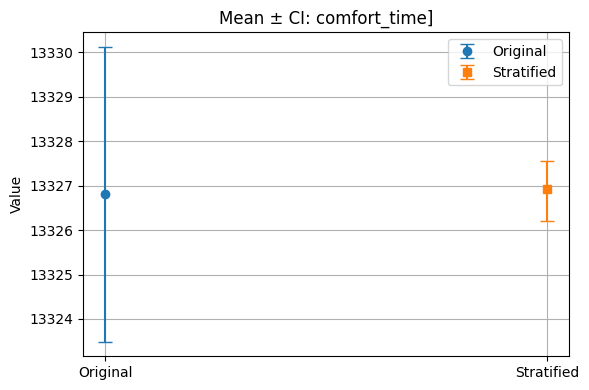

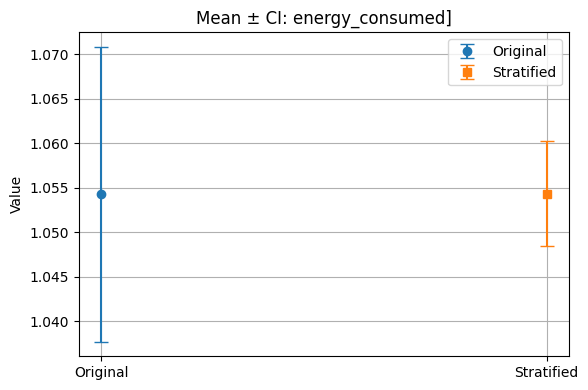

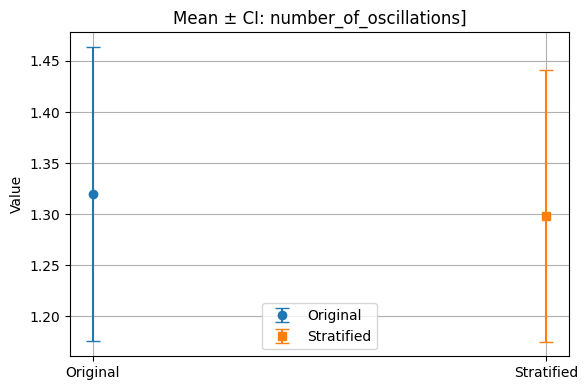

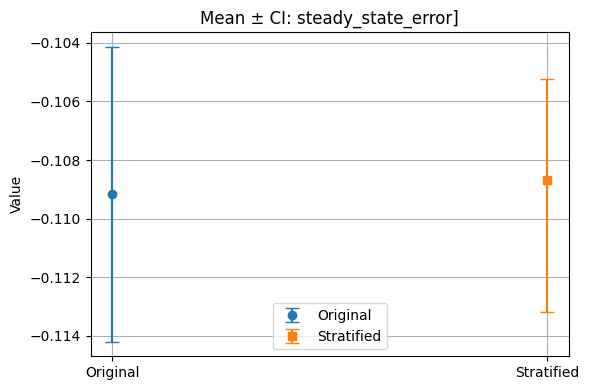

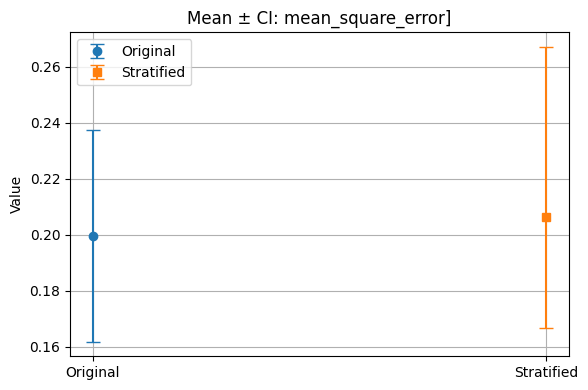

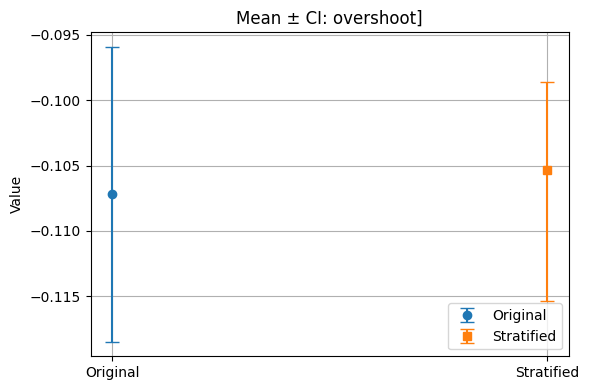

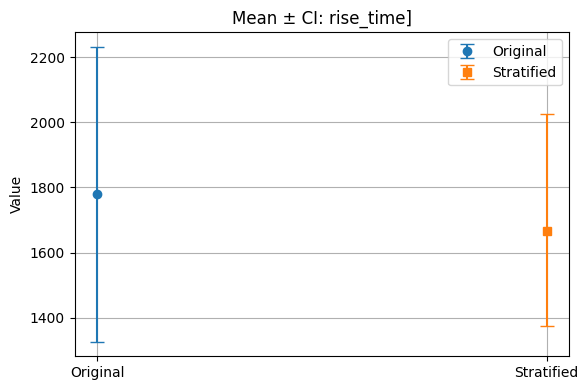

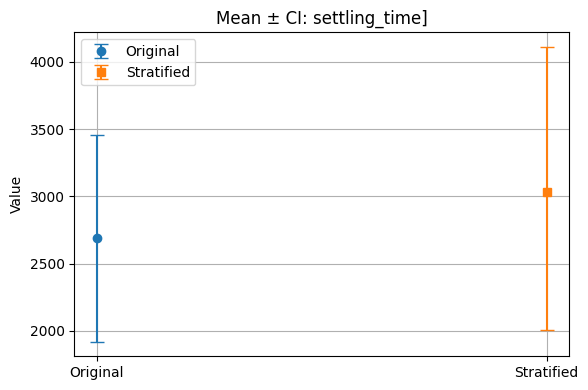

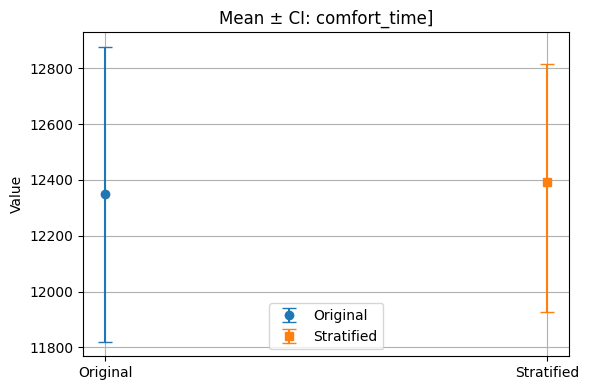

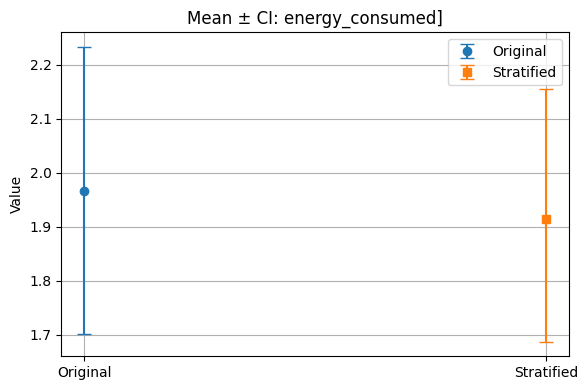

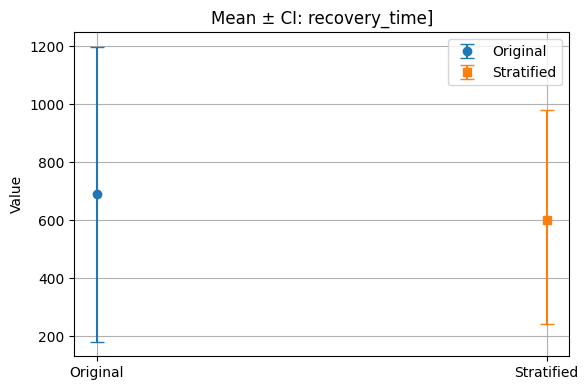

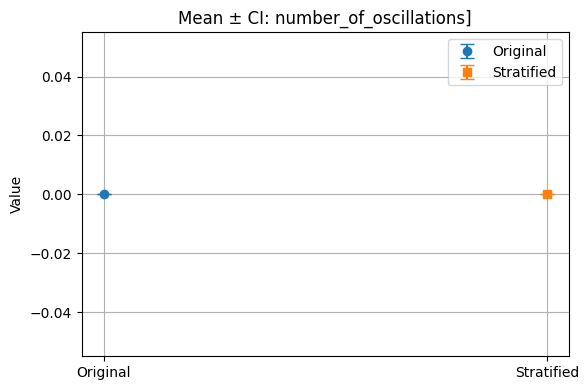

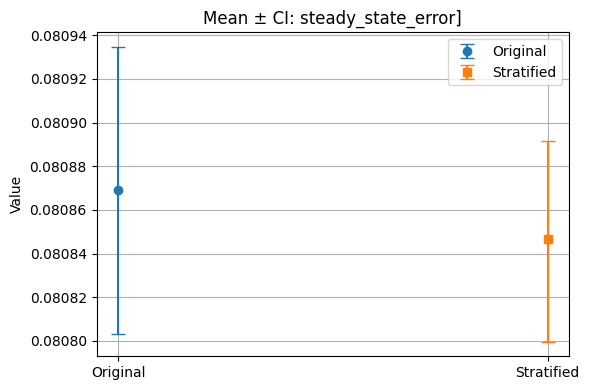

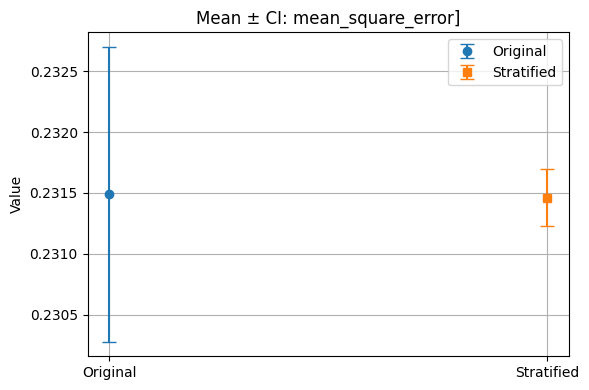

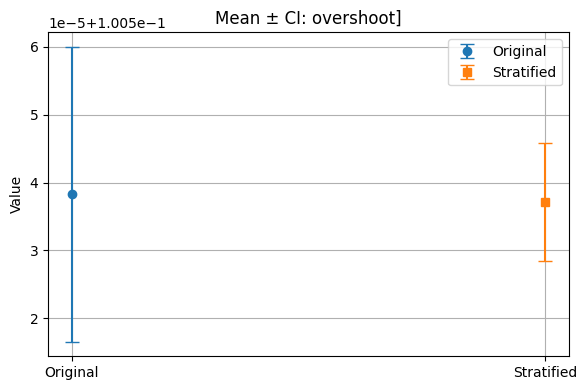

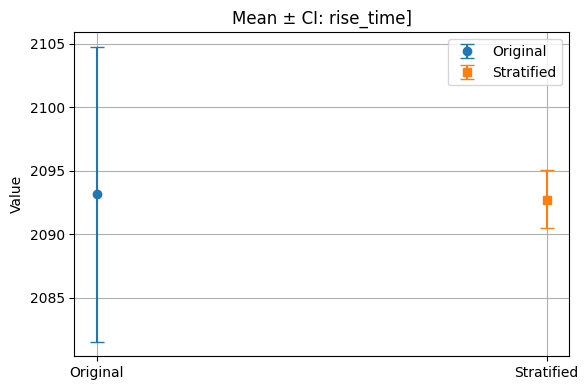

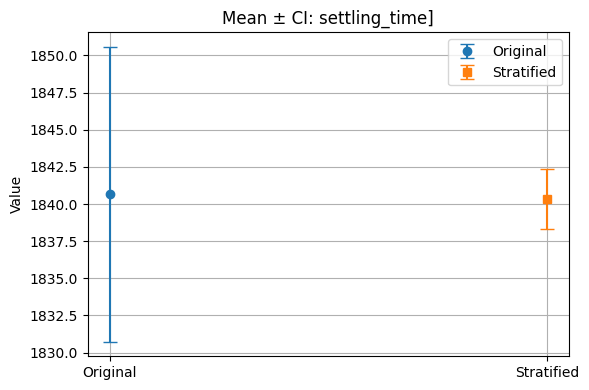

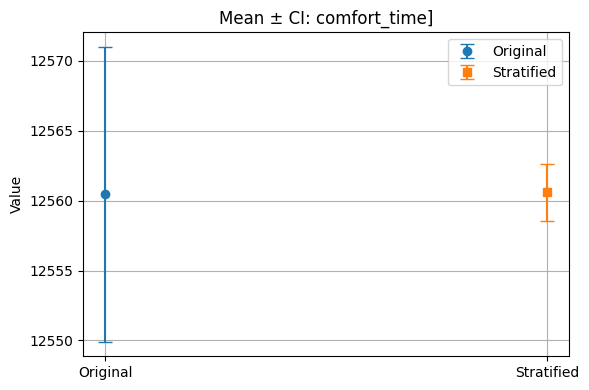

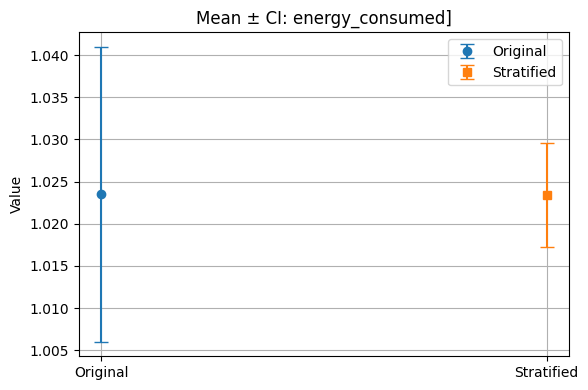

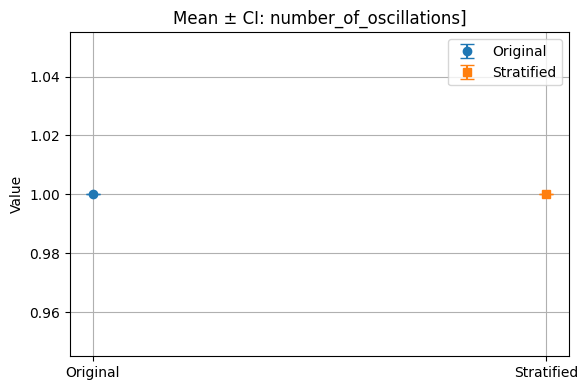

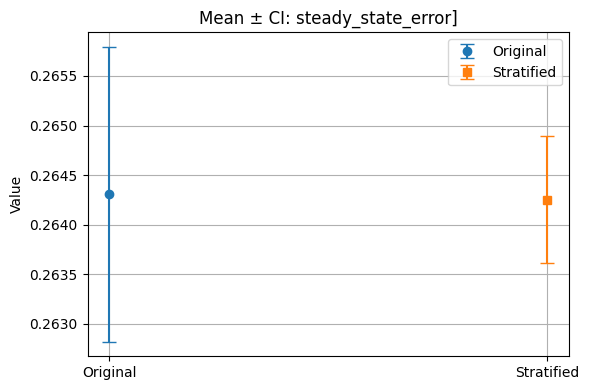

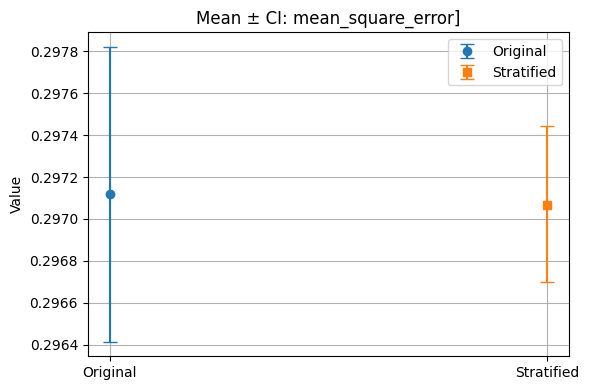

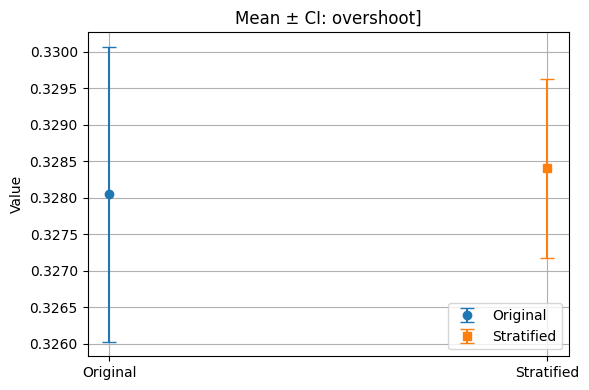

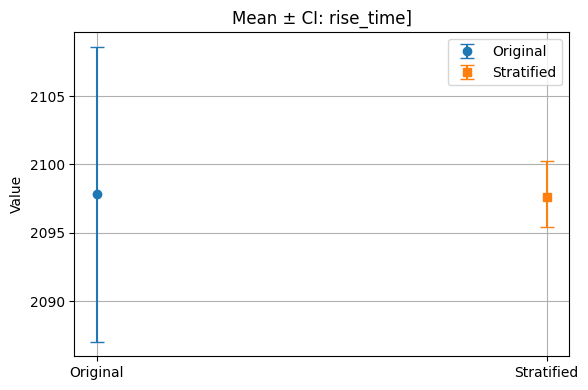

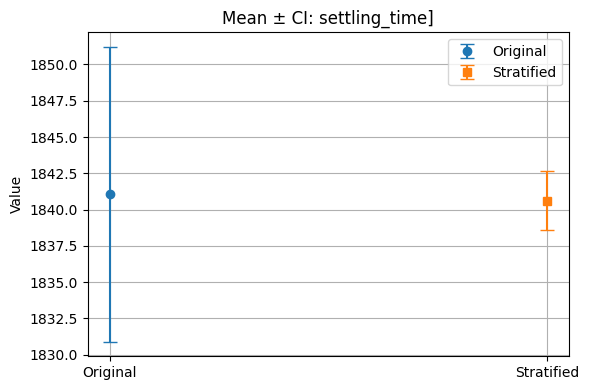

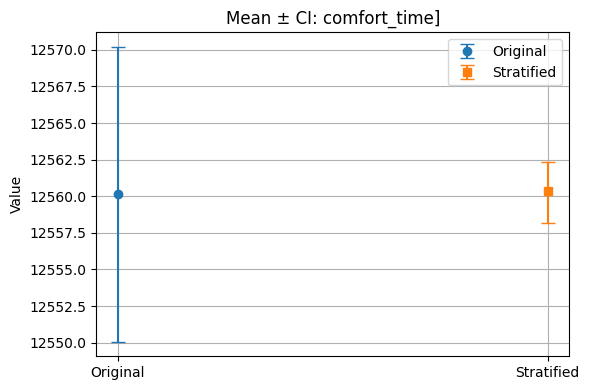

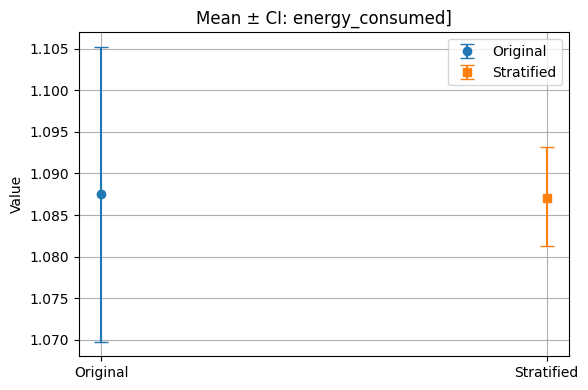

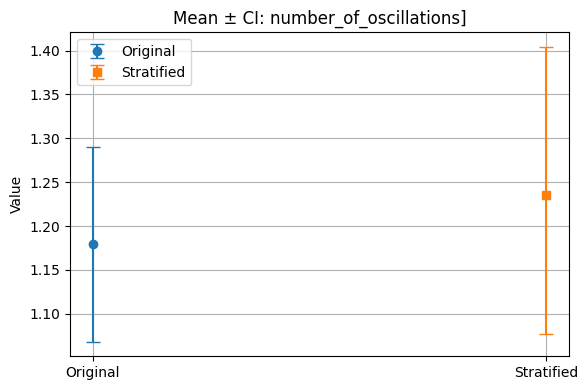

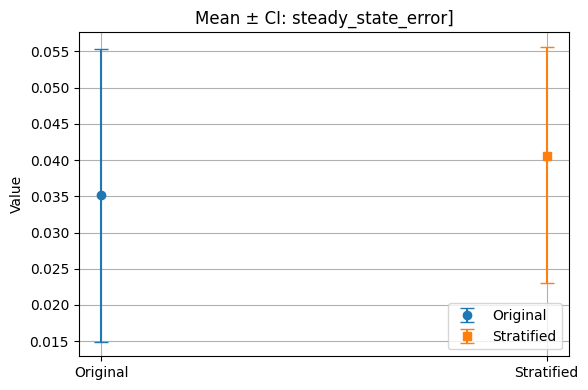

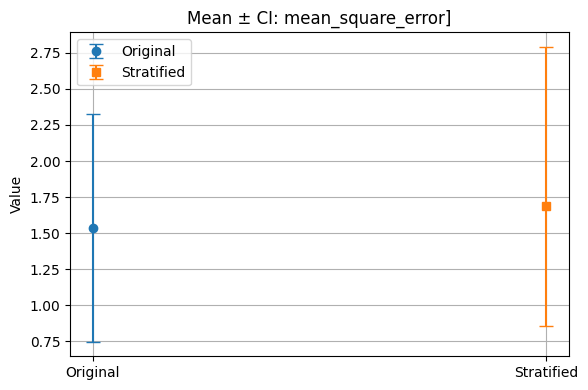

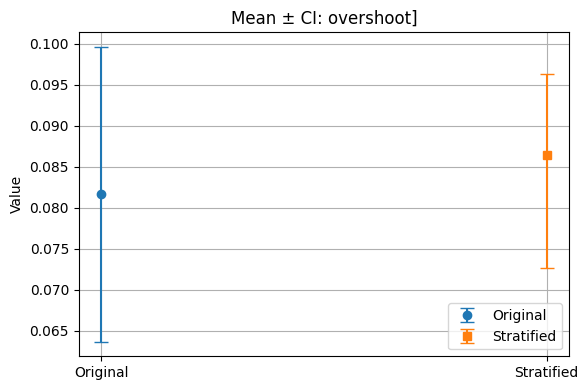

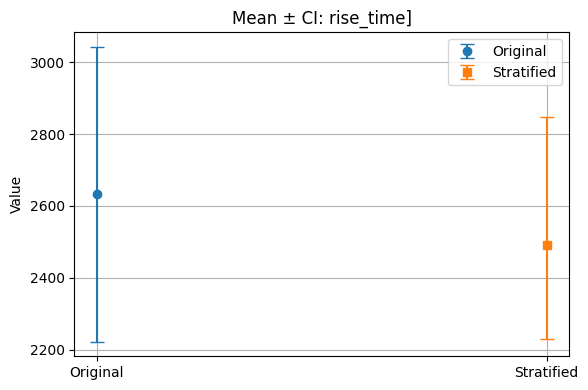

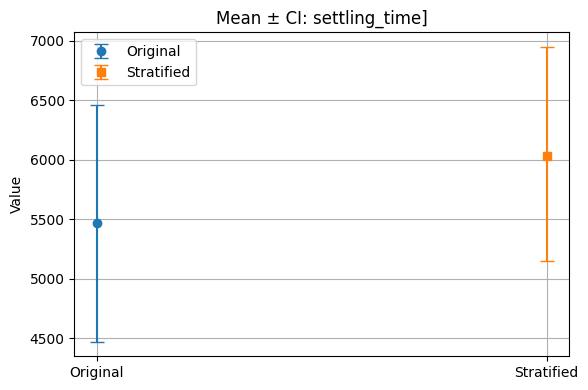

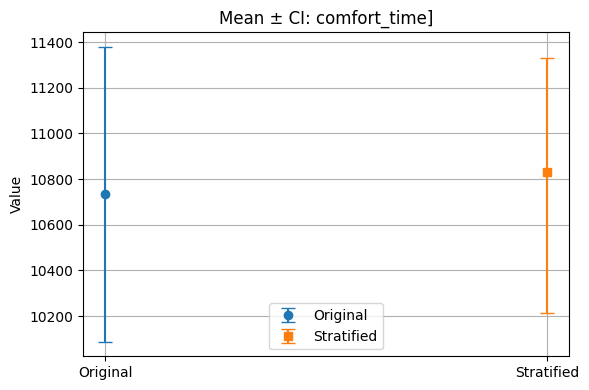

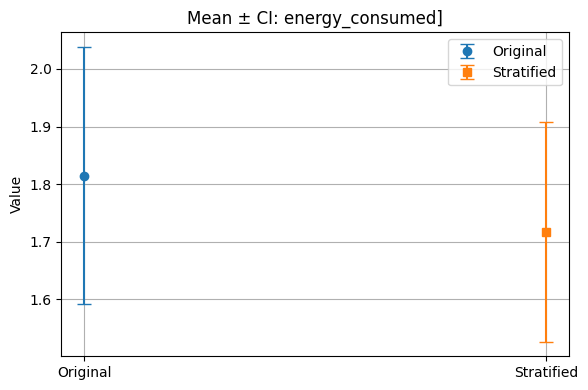

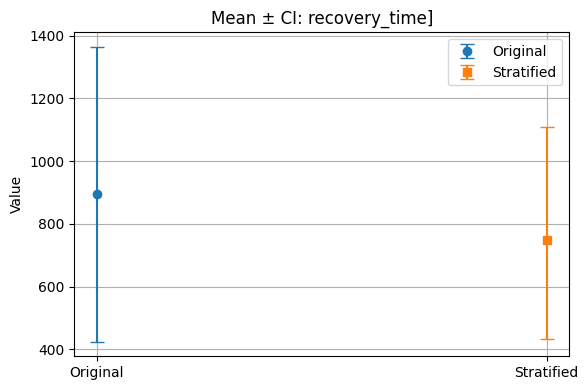

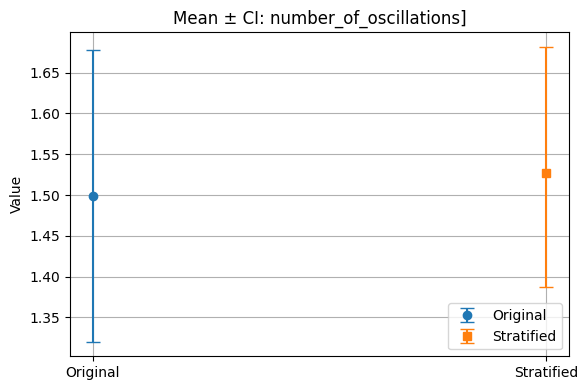

In [4]:
results_files = [
    "simulation_results/statistics/results_pid_nominal_aggregated.csv",
    "simulation_results/statistics/results_pid_with_noise_aggregated.csv",
    "simulation_results/statistics/results_pid_with_disturbances_aggregated.csv",
    "simulation_results/statistics/results_onoff_nominal_aggregated.csv",
    "simulation_results/statistics/results_onoff_with_noise_aggregated.csv",
    "simulation_results/statistics/results_onoff_with_disturbances_aggregated.csv",
    "simulation_results/statistics/results_fuzzy_nominal_aggregated.csv",
    "simulation_results/statistics/results_fuzzy_with_noise_aggregated.csv",
    "simulation_results/statistics/results_fuzzy_with_disturbances_aggregated.csv"
]

results_files_stratified = [
    "simulation_results/statistics/results_pid_nominal_aggregated_low_var.csv",
    "simulation_results/statistics/results_pid_with_noise_aggregated_low_var.csv",
    "simulation_results/statistics/results_pid_with_disturbances_aggregated_low_var.csv",
    "simulation_results/statistics/results_onoff_nominal_aggregated_low_var.csv",
    "simulation_results/statistics/results_onoff_with_noise_aggregated_low_var.csv",
    "simulation_results/statistics/results_onoff_with_disturbances_aggregated_low_var.csv",
    "simulation_results/statistics/results_fuzzy_nominal_aggregated_low_var.csv",
    "simulation_results/statistics/results_fuzzy_with_noise_aggregated_low_var.csv",
    "simulation_results/statistics/results_fuzzy_with_disturbances_aggregated_low_var.csv"
]

for original, stratified in zip(results_files, results_files_stratified):
    # Derive output directory name from file prefix
    output_dir = f"plots/variance_reduction"
    compare_and_plot(original, stratified, output_dir)
